## Kmediods of peaks

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score

import util

In [2]:
# make sure to work with the correct assemblies
if 'snakemake' in globals():
    assemblies = snakemake.params
else:
    import glob
    assemblies = [assemblydir.split("/")[1] for assemblydir in glob.glob("gimme_smooth/**/activity.bayesianridge.score.out.txt")]

print(assemblies)

dfs = dict()
for assembly in assemblies:
    dfs[assembly] = pd.read_csv(f"gimme_smooth/{assembly}_differentialpeaks_100points.tsv", sep="\t", comment="#", index_col=0)

['Astyanax_mexicanus-2.0', 'mm10', 'GRCg6a', 'danRer11', 'ASM223467v1', 'Bl71nemr', 'xenTro9', 'ASM318616v1']


[]

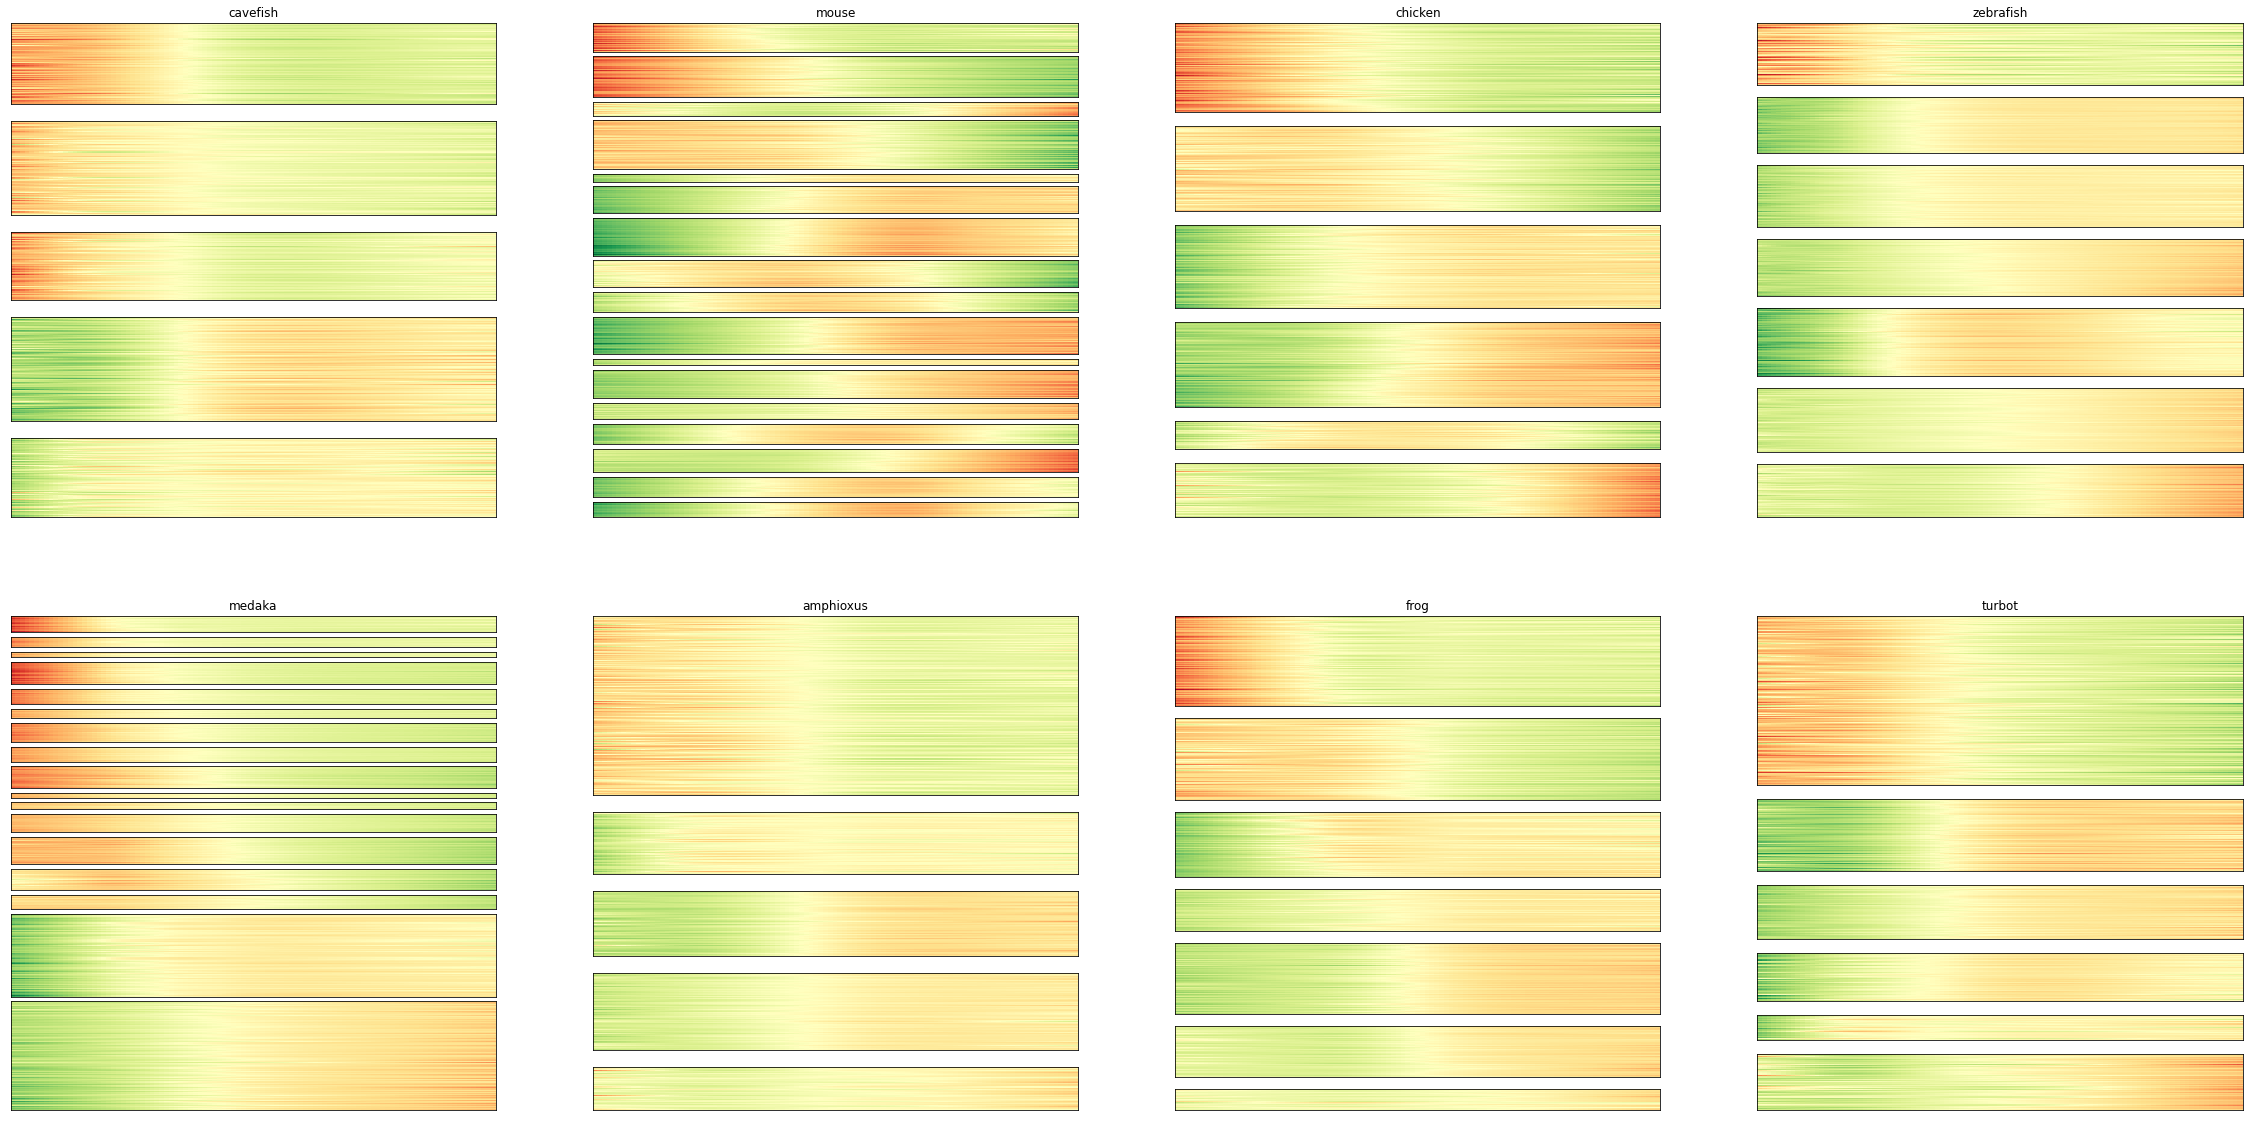

In [3]:
import matplotlib.gridspec as gridspec

# gridspec inside gridspec
f = plt.figure(figsize=(40, 20))

ncols = 4
nrows = len(dfs) // ncols
gs = gridspec.GridSpec(nrows, ncols, figure=f)

nclusters = 5

for i in range(ncols * nrows):
    if i < len(dfs):
        assembly, df = list(dfs.items())[i]
        df = df.subtract(df.mean(axis=1), axis=0)    

        # k-mediods
        corr = df.transpose().corr(method="pearson").values
        sil_score_max = -1
        for n_clusters in range(5,20):
            kmediods = KMedoids(n_clusters=n_clusters, init="k-medoids++").fit(corr)
            labels = kmediods.labels_
            sil_score = silhouette_score(corr, labels)
            if sil_score > sil_score_max:
                sil_score_max = sil_score
                best_n_clusters = n_clusters

        kmediods = KMedoids(n_clusters=best_n_clusters).fit(df)
        df["cluster"] = kmediods.labels_

        mid_vals = [np.mean(np.argmin(df[df["cluster"] == cluster].drop(columns=["cluster"]).values ** 2, axis=1)) for cluster in range(best_n_clusters)]
        start_vals = [np.mean(df[df["cluster"] == cluster][df.columns[0]]) > 0 for cluster in range(best_n_clusters)]

        cluster_order = sorted(range(best_n_clusters), key=lambda e: (start_vals[e], -mid_vals[e]), reverse=True)
        label_counts = [sum(df["cluster"] == cluster) for cluster in cluster_order]

        bigax = gridspec.GridSpecFromSubplotSpec(best_n_clusters, 1, subplot_spec=gs[i], height_ratios=label_counts)

        vmax = (max([np.min(df.drop(columns=["cluster"]).values)**2, np.max(df.drop(columns=["cluster"]).values)**2]))**0.5
        vmin = -vmax
        for i, cluster in enumerate(cluster_order):
            smallax = f.add_subplot(bigax[i, :])
            im = smallax.pcolor(df[df["cluster"] == cluster].drop(columns=["cluster"]), 
                                      vmin=vmin, 
                                      vmax=vmax,
                                      cmap="RdYlGn_r")
            smallax.get_xaxis().set_visible(False)
            smallax.get_yaxis().set_visible(False)

            if i == 0:
                smallax.set_title(f"{util.ass2name(assembly)}")
    else:
        ax = gs[i]
        ax.axis('off')


plt.plot()